<a href="https://colab.research.google.com/github/george-zakharov/ml_notebooks/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libs

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Normalization tests
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest

# Data normalization / standartization
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler

# libs for train tuning
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Boosting
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.svm import SVC

# Model parameters fitting
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score,auc, f1_score, confusion_matrix,precision_score, recall_score, roc_auc_score, roc_curve

# Google files lib
from google.colab import files

# Serialize data
import pickle

import random

# Load Dataset

In [0]:
# Get Kaggle libs
!pip install kaggle

In [0]:
# Upload kaggle user-token
file = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Move it to the root
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [0]:
# Download dataset
!kaggle datasets download -d ronitf/heart-disease-uci

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 5.62MB/s]


In [0]:
# Unzip file
!unzip heart-disease-uci.zip

Archive:  heart-disease-uci.zip
  inflating: heart.csv               


# User defined functions

In [0]:
# Fit models on Grid SearchCV
def grid_search_fitting(models, parameters, X_train, y_train, X_test, y_test): 
  scores = ['accuracy', 'precision', 'recall']
  
  for score in scores:
    clf = GridSearchCV(estimator = models, scoring = score, param_grid = parameters, cv = 5, iid = False)

    clf.fit(X_train, y_train)

    score_test = clf.best_estimator_.score(X_test, y_test) 
    y_pred = clf.predict(X_test)

    print(score)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print("\n")

    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    print('accuracy_on_test: ', score_test)
    print("\n")
  
  return clf

In [0]:

# Data standartization
def scale_std_minmax(df):
  print(df.shape)

  scaler = StandardScaler()
  print(scaler.fit(df.copy()))
  StandardScaler()
  result = scaler.transform(df.copy())
  result = pd.DataFrame(result, columns = df.columns)


  scaler = MinMaxScaler()
  print(scaler.fit(result))
  MinMaxScaler(copy = True, feature_range = (0, 1))
  print(scaler.data_max_)
  result = scaler.transform(result)
  result = pd.DataFrame(result, columns = df.columns)
  
  return result

In [0]:
# Data preprocessing according to skew metrics
def data_preprocessing(df):
  n = 1
  for feature_name in df.columns:
    print(f'\n\n{n}. {feature_name}')
    feature = df[feature_name]

    print_stats(feature)
    
    skew_ = np.abs(skew(feature))

    if (skew_ >= 0.75) and (skew_ < 1.0):
      print('\nДанные рекомендуется логарифмировать\n')
      feature = np.log(feature)
    elif skew_ >= 1:
      if feature.min() > 0:
        print('\nДанные рекомендуется нормализовать методом boxcox\n')
        box_cox_transform = PowerTransformer(method = 'box-cox', standardize = False)
        feature = box_cox_transform.fit_transform(feature.values.reshape(df.shape[0], -1))
      else:
        print('\nДанные рекомендуется нормализовать методом yeo-johnson\n')
        yeo_johnson_transform = PowerTransformer(method = 'yeo-johnson', standardize = False)
        feature = yeo_johnson_transform.fit_transform(feature.values.reshape(df.shape[0], -1))
    else:
      print('\nДанные достаточно стандартизировать\n')

    print_stats(pd.DataFrame(feature, columns = [feature_name]))
    chech_skew(feature)

    df[feature_name] = feature

    n += 1

  return df

In [0]:
# Functions for normalization test
def draw_hist_for_feature(data):
  plt.style.use('ggplot')
  data.hist(bins = 60)
  plt.show()


def chech_skew(feature):
  method_name = '\nSKEW TEST: '
  skew_ = np.abs(skew(feature))
  if (skew_ >= 0.75) and (skew_ < 1.0):
    print(method_name + 'Данные рекомендуется логарифмировать\n')
  elif skew_ >= 1:
    print(method_name + 'Данные рекомендуется нормализовать\n')
  else:
    print(method_name + 'Данные достаточно стандартизировать\n')


def check_shapiro(feature):
  method_name = '\nSHAPIRO TEST: '
  shapiro_ = np.abs(shapiro(feature))
  if (shapiro_[1] < 0.50):
    print(method_name + 'Данные рекомендуется нормализовать\n')
  else:
    print(method_name + 'Данные достаточно стандартизировать\n')


def print_stats(data, need_hist = True):
  if (need_hist == True):
    draw_hist_for_feature(data)

  print("mean : ", np.mean(data))
  print("var  : ", np.var(data))
  print("skew : ", skew(data))
  print("kurt : ", kurtosis(data))
  print("shapiro : ", shapiro(data))
  print("normaltest : ", normaltest(data))


def print_stats_all(df, need_hist = True):
  n = 1
  for feature_name in df.columns:
    print(f'\n\n{n}. {feature_name}')
    print_stats(df[feature_name], need_hist)
    chech_skew(df[feature_name])
    check_shapiro(df[feature_name])
    n += 1

# Dataset exploration

In [0]:
df = pd.read_csv('heart.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


*It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean:*

* age: The person's age in years
* sex: The person's sex (1 = male, 0 = female)
* cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
* chol: The person's cholesterol measurement in mg/dl
* fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* thalach: The person's maximum heart rate achieved
* exang: Exercise induced angina (1 = yes; 0 = no)
* oldpeak: ST depression induced by exercise relative to rest ('ST' relates to * positions on the ECG plot. See more here)
* slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* ca: The number of major vessels (0-3)
* thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
* target: Heart disease (0 = no, 1 = yes)

In [0]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [0]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
# Check classes balance
df['target'].value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

Classes are well-balanced.
No need in balancing.

In [0]:
# Check nulls
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [0]:
# Get features and targets
X = df.drop(['target'], axis = 1)
y = df.target

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


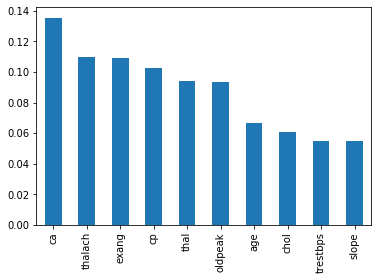

In [0]:
# Check feature importance
model = ExtraTreesClassifier()
model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index = X.columns)

main_features = feat_importances.nlargest(10).index

feat_importances.nlargest(10).plot(kind = 'bar')
plt.show()

In [0]:
# Get 10 main features
X_main = X[main_features]

In [0]:
# Let's see what we got
X_main.head()

,ca,thalach,exang,cp,thal,oldpeak,age,chol,trestbps,slope
0,0,150,0,3,1,2.3,63,233,145,0
1,0,187,0,2,2,3.5,37,250,130,0
2,0,172,0,1,2,1.4,41,204,130,2
3,0,178,0,1,2,0.8,56,236,120,2
4,0,163,1,0,2,0.6,57,354,120,2


In [0]:
# Divide numerical and categorical data
X_num = X_main.drop(['thal', 'cp', 'ca', 'exang', 'slope'], axis = 1)
X_cat = X_main[['thal', 'cp', 'ca', 'exang', 'slope']]



1. thalach


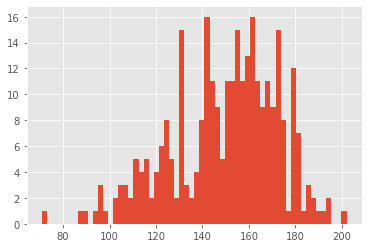

mean :  149.64686468646866
var  :  522.9148994107329
skew :  -0.5347455419075503
kurt :  -0.08068888039194055
shapiro :  (0.9763151407241821, 6.620309432037175e-05)
normaltest :  NormaltestResult(statistic=13.46672289054534, pvalue=0.0011905243421222172)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



2. oldpeak


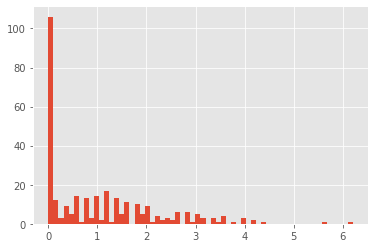

mean :  1.0396039603960396
var  :  1.3436460477730934
skew :  1.2634255245891595
kurt :  1.5301925815010025
shapiro :  (0.8441835045814514, 8.183467206576554e-17)
normaltest :  NormaltestResult(statistic=66.6201580770229, pvalue=3.4167757949760942e-15)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



3. age


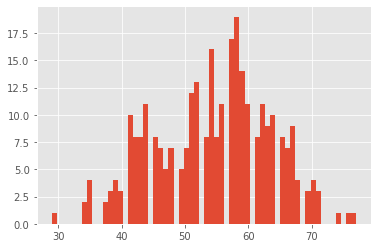

mean :  54.366336633663366
var  :  82.21233212430155
skew :  -0.2014596901125439
kurt :  -0.55299857127345
shapiro :  (0.9863710999488831, 0.005800189916044474)
normaltest :  NormaltestResult(statistic=8.74798581312778, pvalue=0.012600826063683705)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



4. chol


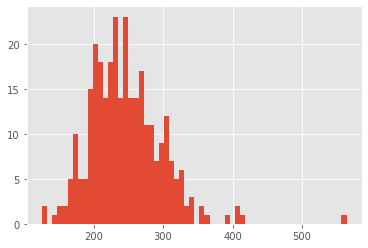

mean :  246.26402640264027
var  :  2677.5606530950135
skew :  1.1377326187082244
kurt :  4.411682119729873
shapiro :  (0.9468814134597778, 5.364669153351542e-09)
normaltest :  NormaltestResult(statistic=83.50370500964404, pvalue=7.368869203474054e-19)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



5. trestbps


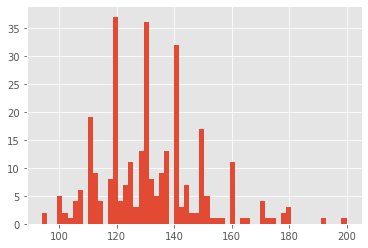

mean :  131.62376237623764
var  :  306.5713165375941
skew :  0.7102300604861443
kurt :  0.8940569555069118
shapiro :  (0.965917706489563, 1.4579997014152468e-06)
normaltest :  NormaltestResult(statistic=28.567604502994023, pvalue=6.260708761946876e-07)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



In [0]:
# Check normalization
print_stats_all(X_num)

# Dataset transformation

## Normalization

In [0]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 5 columns):
thalach     303 non-null int64
oldpeak     303 non-null float64
age         303 non-null int64
chol        303 non-null int64
trestbps    303 non-null int64
dtypes: float64(1), int64(4)
memory usage: 12.0 KB




1. thalach


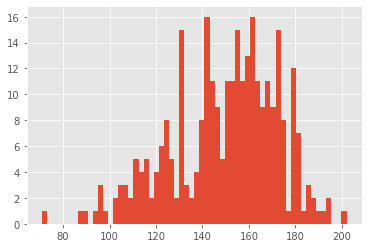

mean :  149.64686468646866
var  :  522.9148994107329
skew :  -0.5347455419075503
kurt :  -0.08068888039194055
shapiro :  (0.9763151407241821, 6.620309432037175e-05)
normaltest :  NormaltestResult(statistic=13.46672289054534, pvalue=0.0011905243421222172)

Данные достаточно стандартизировать



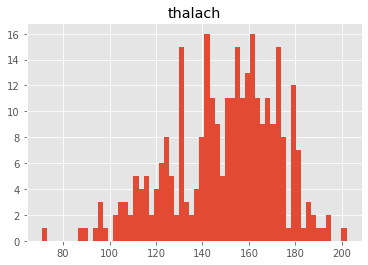

mean :  thalach    149.646865
dtype: float64
var  :  thalach    522.914899
dtype: float64
skew :  [-0.53474554]
kurt :  [-0.08068888]
shapiro :  (0.9763151407241821, 6.620309432037175e-05)
normaltest :  NormaltestResult(statistic=array([13.46672289]), pvalue=array([0.00119052]))

SKEW TEST: Данные достаточно стандартизировать



2. oldpeak


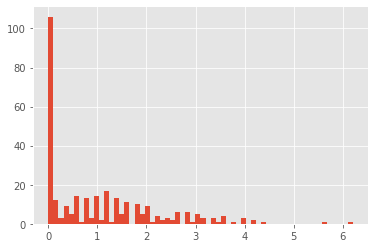

mean :  1.0396039603960396
var  :  1.3436460477730934
skew :  1.2634255245891595
kurt :  1.5301925815010025
shapiro :  (0.8441835045814514, 8.183467206576554e-17)
normaltest :  NormaltestResult(statistic=66.6201580770229, pvalue=3.4167757949760942e-15)

Данные рекомендуется нормализовать методом yeo-johnson



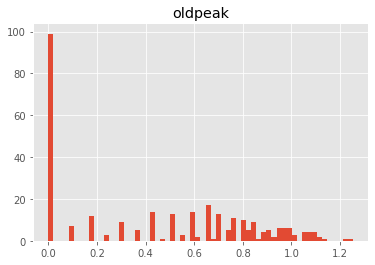

mean :  oldpeak    0.445135
dtype: float64
var  :  oldpeak    0.146941
dtype: float64
skew :  [0.12362192]
kurt :  [-1.42218346]
shapiro :  (0.878540575504303, 9.218566190895457e-15)
normaltest :  NormaltestResult(statistic=array([3236.44009043]), pvalue=array([0.]))

SKEW TEST: Данные достаточно стандартизировать



3. age


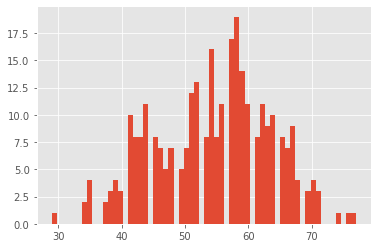

mean :  54.366336633663366
var  :  82.21233212430155
skew :  -0.2014596901125439
kurt :  -0.55299857127345
shapiro :  (0.9863710999488831, 0.005800189916044474)
normaltest :  NormaltestResult(statistic=8.74798581312778, pvalue=0.012600826063683705)

Данные достаточно стандартизировать



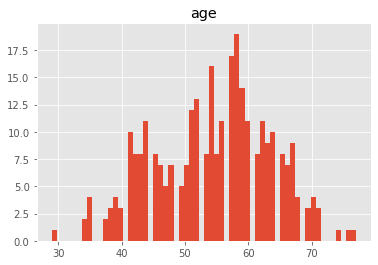

mean :  age    54.366337
dtype: float64
var  :  age    82.212332
dtype: float64
skew :  [-0.20145969]
kurt :  [-0.55299857]
shapiro :  (0.9863710999488831, 0.005800189916044474)
normaltest :  NormaltestResult(statistic=array([8.74798581]), pvalue=array([0.01260083]))

SKEW TEST: Данные достаточно стандартизировать



4. chol


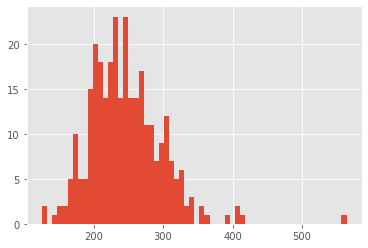

mean :  246.26402640264027
var  :  2677.5606530950135
skew :  1.1377326187082244
kurt :  4.411682119729873
shapiro :  (0.9468814134597778, 5.364669153351542e-09)
normaltest :  NormaltestResult(statistic=83.50370500964404, pvalue=7.368869203474054e-19)

Данные рекомендуется нормализовать методом boxcox



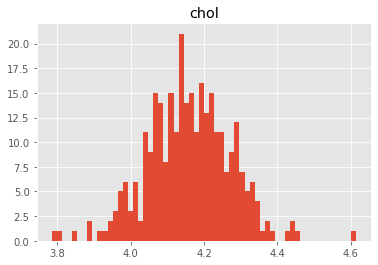

mean :  chol    4.159172
dtype: float64
var  :  chol    0.012939
dtype: float64
skew :  [-0.00594408]
kurt :  [0.81329289]
shapiro :  (0.9928715825080872, 0.15816503763198853)
normaltest :  NormaltestResult(statistic=array([5.72760579]), pvalue=array([0.05705139]))

SKEW TEST: Данные достаточно стандартизировать



5. trestbps


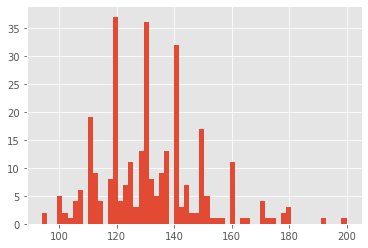

mean :  131.62376237623764
var  :  306.5713165375941
skew :  0.7102300604861443
kurt :  0.8940569555069118
shapiro :  (0.965917706489563, 1.4579997014152468e-06)
normaltest :  NormaltestResult(statistic=28.567604502994023, pvalue=6.260708761946876e-07)

Данные достаточно стандартизировать



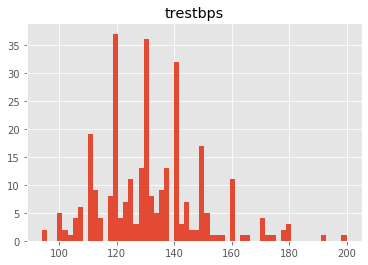

mean :  trestbps    131.623762
dtype: float64
var  :  trestbps    306.571317
dtype: float64
skew :  [0.71023006]
kurt :  [0.89405696]
shapiro :  (0.965917706489563, 1.4579997014152468e-06)
normaltest :  NormaltestResult(statistic=array([28.5676045]), pvalue=array([6.26070876e-07]))

SKEW TEST: Данные достаточно стандартизировать



In [0]:
X_num_normalized = data_preprocessing(X_num)

## Standartization

In [0]:
X_num_scaled = scale_std_minmax(X_num_normalized)

(303, 5)
StandardScaler(copy=True, with_mean=True, with_std=True)
MinMaxScaler(copy=True, feature_range=(0, 1))
[2.28942904 2.105124   2.49624017 4.0055063  3.90516547]


In [0]:
X_num_scaled.head()

,thalach,oldpeak,age,chol,trestbps
0,0.603053,0.717078,0.708333,0.429459,0.481132
1,0.885496,0.842972,0.166667,0.476894,0.339623
2,0.770992,0.565692,0.250000,0.338959,0.339623
3,0.816794,0.406471,0.562500,0.438103,0.245283
4,0.702290,0.334344,0.583333,0.706065,0.245283


In [0]:
X_num_scaled.describe()

,thalach,oldpeak,age,chol,trestbps
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.600358,0.355514,0.528465,0.451248,0.354941
std,0.174849,0.306658,0.189210,0.137226,0.165454
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.477099,0.000000,0.385417,0.362051,0.245283
50%,0.625954,0.406471,0.541667,0.449440,0.339623
75%,0.725191,0.606051,0.666667,0.539321,0.433962
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Prepare train/test data

In [0]:
X_processed = pd.concat([X_num_scaled, X_cat], axis = 1)

In [0]:
X_processed.head()

,thalach,oldpeak,age,chol,trestbps,thal,cp,ca,exang,slope
0,0.603053,0.717078,0.708333,0.429459,0.481132,1,3,0,0,0
1,0.885496,0.842972,0.166667,0.476894,0.339623,2,2,0,0,0
2,0.770992,0.565692,0.250000,0.338959,0.339623,2,1,0,0,2
3,0.816794,0.406471,0.562500,0.438103,0.245283,2,1,0,0,2
4,0.702290,0.334344,0.583333,0.706065,0.245283,2,0,0,1,2


In [0]:
X_processed.describe()

,thalach,oldpeak,age,chol,trestbps,thal,cp,ca,exang,slope
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.600358,0.355514,0.528465,0.451248,0.354941,2.313531,0.966997,0.729373,0.326733,1.399340
std,0.174849,0.306658,0.189210,0.137226,0.165454,0.612277,1.032052,1.022606,0.469794,0.616226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.477099,0.000000,0.385417,0.362051,0.245283,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.625954,0.406471,0.541667,0.449440,0.339623,2.000000,1.000000,0.000000,0.000000,1.000000
75%,0.725191,0.606051,0.666667,0.539321,0.433962,3.000000,2.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,4.000000,1.000000,2.000000


In [0]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.2, random_state = 42)

# Training

## Find best classifier

In [0]:
GaussianNB_param = {'var_smoothing':  [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0]}
grid_search_fitting(GaussianNB(), GaussianNB_param, X_train, y_train, X_test, y_test)

accuracy
GaussianNB(priors=None, var_smoothing=0.2)
0.8183383991894629


Confusion matrix:
[[25  4]
 [ 4 28]]
accuracy_on_test:  0.8688524590163934


precision
GaussianNB(priors=None, var_smoothing=0.1)
0.7929629629629631


Confusion matrix:
[[26  3]
 [ 4 28]]
accuracy_on_test:  0.8852459016393442


recall
GaussianNB(priors=None, var_smoothing=0.9)
0.9327635327635327


Confusion matrix:
[[24  5]
 [ 3 29]]
accuracy_on_test:  0.8688524590163934




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=False,
             n_jobs=None,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1, 0.2, 0.5,
                                           0.75, 0.9, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [0]:
BernoulliNB_param = {'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0], 
                     'binarize': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0],
                     'fit_prior': ['True', 'False']}
grid_search_fitting(BernoulliNB(), BernoulliNB_param, X_train, y_train, X_test, y_test)

accuracy
BernoulliNB(alpha=0.1, binarize=0.75, class_prior=None, fit_prior='True')
0.8139130120133158


Confusion matrix:
[[22  7]
 [ 5 27]]
accuracy_on_test:  0.8032786885245902


precision
BernoulliNB(alpha=0.1, binarize=0.75, class_prior=None, fit_prior='True')
0.7983912165780909


Confusion matrix:
[[22  7]
 [ 5 27]]
accuracy_on_test:  0.8032786885245902


recall
BernoulliNB(alpha=1e-09, binarize=1e-09, class_prior=None, fit_prior='True')
0.8951566951566953


Confusion matrix:
[[22  7]
 [ 5 27]]
accuracy_on_test:  0.8032786885245902




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid=False, n_jobs=None,
             param_grid={'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0],
                         'binarize': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                      0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9,
                                      1.0],
                         'fit_prior': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [0]:
SVM_param = {'C': [0.1, 1, 10]}
grid_search_fitting(SVC(), SVM_param, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

accuracy
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.8062671877261544


Confusion matrix:
[[24  5]
 [ 4 28]]
accuracy_on_test:  0.8524590163934426


precision
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.8012684110860828


Confusion matrix:
[[26  3]
 [ 5 27]]
accuracy_on_test:  0.8688524590163934


recall
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.9022792022792023


Confusion matrix:
[[24  5]
 [ 5 27

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [0]:
RF_param = {'n_estimators': [10, 20, 30, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, None], 'min_samples_split': [2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5]}
grid_search_fitting(RandomForestClassifier(), RF_param, X_train, y_train, X_test, y_test)

accuracy
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.8393526559559994


Confusion matrix:
[[24  5]
 [ 3 29]]
accuracy_on_test:  0.8688524590163934


precision
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jo

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

## Train on best classifier

In [0]:
clf = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 2, max_features = 'auto', max_leaf_nodes = None,
                             min_impurity_decrease = 0.0, min_impurity_split = None, min_samples_leaf = 1, min_samples_split = 3,
                             min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = None, oob_score = False, random_state = None,
                             verbose = 0, warm_start = False)

In [0]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
X_test

,thalach,oldpeak,age,chol,trestbps,thal,cp,ca,exang,slope
179,0.312977,0.334344,0.583333,0.542942,0.528302,1,0,1,1,1
228,0.671756,0.139143,0.625000,0.571140,0.716981,3,3,0,0,1
111,0.778626,0.139143,0.583333,0.000000,0.528302,3,2,1,0,2
246,0.603053,0.658558,0.562500,0.798762,0.377358,3,0,2,1,1
60,0.450382,0.000000,0.875000,0.515875,0.150943,2,2,1,0,2
...,...,...,...,...,...,...,...,...,...,...
249,0.572519,0.674281,0.833333,0.487537,0.433962,3,2,3,0,1
104,0.702290,0.000000,0.437500,0.311471,0.330189,2,2,0,0,2
300,0.534351,0.834495,0.812500,0.300841,0.471698,3,0,2,0,1
193,0.541985,0.776780,0.645833,0.557207,0.481132,3,0,2,1,1


In [0]:
X_test.describe()

,thalach,oldpeak,age,chol,trestbps,thal,cp,ca,exang,slope
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.586159,0.358464,0.520492,0.445804,0.402258,2.360656,0.868852,0.918033,0.377049,1.311475
std,0.191521,0.331778,0.180040,0.137235,0.183563,0.683930,1.071998,1.129824,0.488669,0.646555
min,0.000000,0.000000,0.104167,0.000000,0.075472,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.465649,0.000000,0.354167,0.352260,0.283019,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.587786,0.334344,0.541667,0.463322,0.386792,2.000000,0.000000,0.000000,0.000000,1.000000
75%,0.740458,0.658558,0.645833,0.535680,0.528302,3.000000,2.000000,2.000000,1.000000,2.000000
max,0.923664,1.000000,0.875000,0.798762,1.000000,3.000000,3.000000,4.000000,1.000000,2.000000


In [0]:
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [0]:
print(clf.predict([[0.6,	0.1,	0.4,	0.7,	0.8,	3,	3,	0,	0,	1]]))

[1]


In [0]:
pickle.dump(clf, open('model.pkl', 'wb'))

In [0]:
#model = pickle.load(open('model.pkl','rb'))

# App functions

In [0]:
test_row

,oldpeak,thalach,age,trestbps,chol,thal,cp,ca,exang,slope
0,0.586478,0.473282,0.0,0.216981,0.446626,0,3,0,1,1


In [0]:
test_row.values

array([[0.46747093, 0.67175573, 0.33333333, 0.73584906, 0.48223853,
        0.        , 2.        , 2.        , 0.        , 2.        ]])

In [0]:
print(clf.predict(test_row))

[1]


In [0]:
pickle.dump(X_processed, open('X_processed.pkl', 'wb'))

# Useful links

* https://www.kaggle.com/ronitf/heart-disease-uci (dataset page)
* https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model (good dataset exploration)